In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [ ]:
# # Label remapping
# label_map = {
#     'alert': 'alert', 'Not drowsy': 'alert', 'Not Drowsy': 'alert',
#     'Slightly drowsy': 'slightly', 'Slightly Drowsy': 'slightly', 'slightly': 'slightly',
#     'Moderately drowsy': 'very', 'Moderately Drowsy': 'very', 'Very drowsy': 'very',
#     'very': 'very', 'moderately': 'very'
# }

# label_map = {
#     'Not Drowsy': 'alert', 'Slight': 'slightly', 'Moderate': 'moderate_very', 'Very': 'moderate_very'
# }

label_map = {
    'Not Drowsy': 'alert_slight', 'Slight': 'slightly', 'Moderate': 'moderate_very', 'Very': 'moderate_very'
}

# Feature list
# features = [
#     'EAR_mean', 'MAR_inner', 'MAR_outer',
#     'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
#     'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz',
#     'gaze_angle_x', 'gaze_angle_y',
#     'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'

features = [
    'EAR_mean_mean', 'MAR_inner_mean', 'MAR_outer_mean', 'AU01_r_mean', 'AU15_r_mean', 'AU25_r_mean', 'AU26_r_mean',
    'AU45_r_mean', 'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean',
    'gaze_angle_x_mean', 'gaze_angle_y_mean', 'swAngle_mean', 'laneDevPosition_mean', 'laneDev_OffsetfrmLaneCentre_mean',
    'speed_mean', 'EAR_mean_std', 'MAR_inner_std', 'MAR_outer_std', 'AU01_r_std', 'AU15_r_std',
    'AU25_r_std', 'AU26_r_std', 'AU45_r_std', 'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std',
    'pose_Rz_std', 'gaze_angle_x_std', 'gaze_angle_y_std', 'swAngle_std', 'laneDevPosition_std',
    'laneDev_OffsetfrmLaneCentre_std', 'speed_std'
]

# features = [
#     'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean', 
#     'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std', 'pose_Rz_std'
# ]

📊 Class distribution in training set BEFORE SMOTE:
  slightly: 3867 samples
  moderate_very: 3449 samples
  alert: 1633 samples

📊 Class distribution in test set:
  slightly: 822 samples
  moderate_very: 678 samples
  alert: 535 samples

📊 Class distribution in training set AFTER SMOTE:
  alert: 3867 samples
  slightly: 3867 samples
  moderate_very: 3867 samples


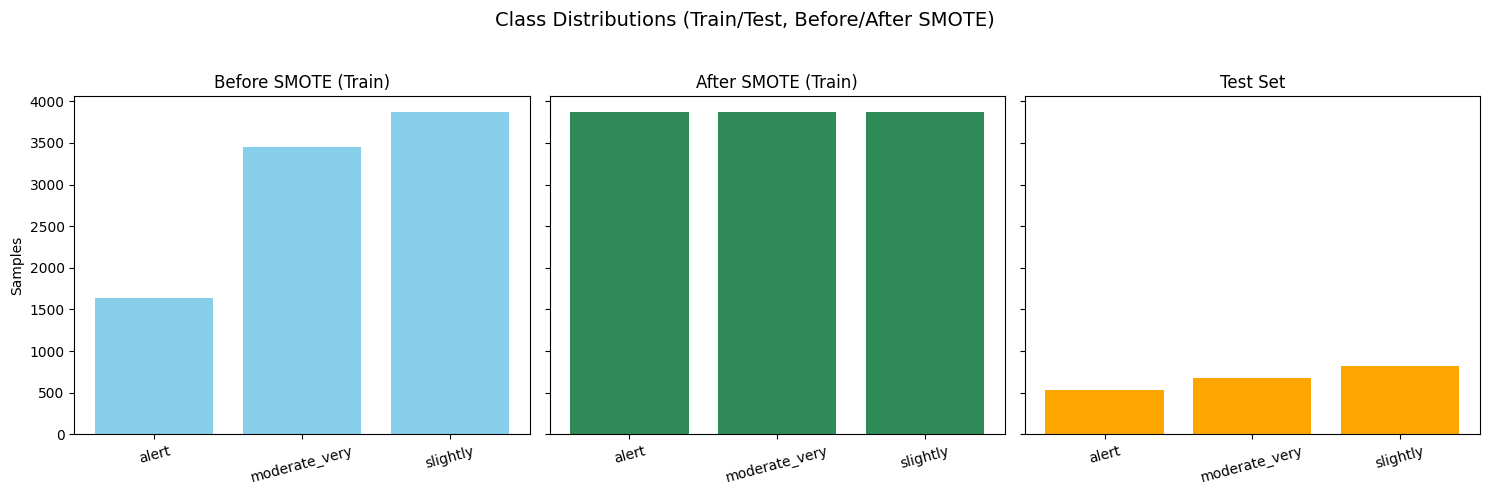

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# --- Map and clean labels ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Extract features and labels ---
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode string labels to integers ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Class distribution BEFORE SMOTE ---
print("📊 Class distribution in training set BEFORE SMOTE:")
before_counts = y_train.value_counts()
for label, count in before_counts.items():
    print(f"  {label}: {count} samples")

# --- Class distribution in TEST set ---
print("\n📊 Class distribution in test set:")
test_counts = y_test.value_counts()
for label, count in test_counts.items():
    print(f"  {label}: {count} samples")

# --- Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Class distribution AFTER SMOTE ---
y_train_labels_sm = le.inverse_transform(y_train_sm)
after_counts = pd.Series(y_train_labels_sm).value_counts()

print("\n📊 Class distribution in training set AFTER SMOTE:")
for label, count in after_counts.items():
    print(f"  {label}: {count} samples")

# --- Custom label order (if you want consistent axis order) ---
all_labels = sorted(set(before_counts.index).union(after_counts.index).union(test_counts.index))

# --- Reindex for plotting ---
before_counts = before_counts.reindex(all_labels, fill_value=0)
after_counts = after_counts.reindex(all_labels, fill_value=0)
test_counts = test_counts.reindex(all_labels, fill_value=0)

# --- Plot 1×3 comparison ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Before SMOTE
axes[0].bar(before_counts.index, before_counts.values, color='skyblue')
axes[0].set_title("Before SMOTE (Train)")
axes[0].set_ylabel("Samples")
axes[0].tick_params(axis='x', rotation=15)

# After SMOTE
axes[1].bar(after_counts.index, after_counts.values, color='seagreen')
axes[1].set_title("After SMOTE (Train)")
axes[1].tick_params(axis='x', rotation=15)

# Test Set
axes[2].bar(test_counts.index, test_counts.values, color='orange')
axes[2].set_title("Test Set")
axes[2].tick_params(axis='x', rotation=15)

plt.suptitle("Class Distributions (Train/Test, Before/After SMOTE)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Dummy Classifier (Binary):

              precision    recall  f1-score   support

       alert       0.29      0.20      0.24       535
      drowsy       0.74      0.83      0.78      1500

    accuracy                           0.66      2035
   macro avg       0.52      0.51      0.51      2035
weighted avg       0.63      0.66      0.64      2035



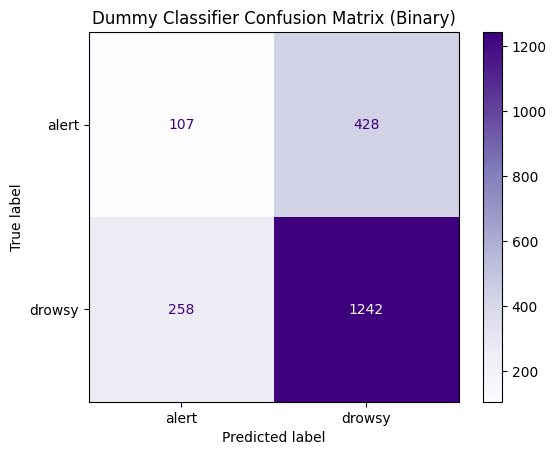

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# --- Load CSVs ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Apply mapping ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

# --- Drop rows with unmapped labels ---
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Convert multiclass to binary ---
def binarize_label(label):
    return 'alert' if label == 'alert' else 'drowsy'

train_df['BinaryLabel'] = train_df['Label'].apply(binarize_label)
test_df['BinaryLabel'] = test_df['Label'].apply(binarize_label)

# --- Feature list ---
features = [col for col in train_df.columns if col not in ['Label', 'BinaryLabel']]

# --- Extract features and binary labels ---
X_train = train_df[features]
y_train = train_df['BinaryLabel']
X_test = test_df[features]
y_test = test_df['BinaryLabel']

# --- Encode binary labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # alert → 0, drowsy → 1
y_test_enc = le.transform(y_test)

# --- Fit dummy classifier ---
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train_enc)

# --- Predict ---
y_pred_dummy = dummy_clf.predict(X_test)

# --- Custom order ---
custom_order = ['alert', 'drowsy']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Classification report ---
print("Dummy Classifier (Binary):\n")
print(classification_report(
    y_test_enc,
    y_pred_dummy,
    labels=custom_label_indices,
    target_names=custom_order
))

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_dummy,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Purples'
)
plt.title("Dummy Classifier Confusion Matrix (Binary)")
plt.show()

Random Forest (Binary Evaluation):

              precision    recall  f1-score   support

       alert       0.43      0.13      0.20       535
      drowsy       0.75      0.94      0.83      1500

    accuracy                           0.73      2035
   macro avg       0.59      0.53      0.52      2035
weighted avg       0.67      0.73      0.67      2035

Binary F1 Score (macro): 0.5183
Binary F1 Score (weighted): 0.6681
Binary ROC AUC: 0.7207


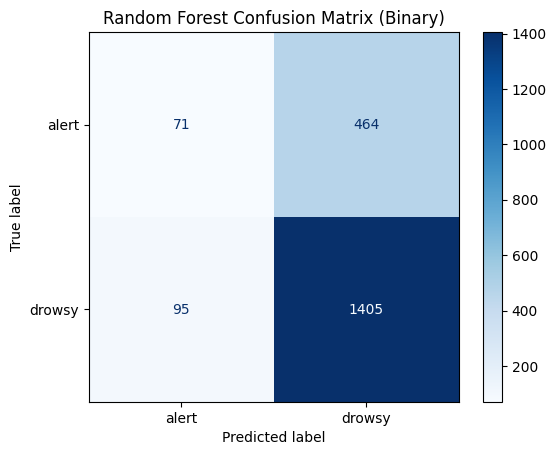

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# --- Load data ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Apply label map ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Features ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels (multiclass) ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- SMOTE on multiclass labels ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train multiclass Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

# --- Predict multiclass ---
y_pred_mc = rf_model.predict(X_test)
y_proba_mc = rf_model.predict_proba(X_test)  # Shape: (n_samples, 3)

# ===============================
# Recast multiclass → binary
# ===============================

# Get class name mapping
class_names = le.classes_

# Define binary mapping
def multiclass_to_binary(y):
    return np.where(np.isin(y, [le.transform(['slightly'])[0], le.transform(['moderate_very'])[0]]), 1, 0)

# --- Convert predictions and true labels to binary ---
y_test_bin = multiclass_to_binary(y_test_enc)
y_pred_bin = multiclass_to_binary(y_pred_mc)

# --- Compute probability of "drowsy" = slightly + moderate_very ---
drowsy_indices = [le.transform(['slightly'])[0], le.transform(['moderate_very'])[0]]
y_proba_bin = y_proba_mc[:, drowsy_indices].sum(axis=1)  # P(drowsy)

# --- Evaluate Binary Classification ---
print("Random Forest (Binary Evaluation):\n")
print(classification_report(
    y_test_bin,
    y_pred_bin,
    target_names=['alert', 'drowsy']
))

# --- Binary F1 Score ---
f1_bin_macro = f1_score(y_test_bin, y_pred_bin, average='macro')
f1_bin_weighted = f1_score(y_test_bin, y_pred_bin, average='weighted')
print(f"Binary F1 Score (macro): {f1_bin_macro:.4f}")
print(f"Binary F1 Score (weighted): {f1_bin_weighted:.4f}")

# --- ROC AUC for binary ---
auc_bin = roc_auc_score(y_test_bin, y_proba_bin)
print(f"Binary ROC AUC: {auc_bin:.4f}")

# --- Binary confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_bin,
    y_pred_bin,
    display_labels=['alert', 'drowsy'],
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Binary)")
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (Binary Evaluation):

              precision    recall  f1-score   support

       alert       0.47      0.21      0.29       535
      drowsy       0.76      0.91      0.83      1500

    accuracy                           0.73      2035
   macro avg       0.62      0.56      0.56      2035
weighted avg       0.69      0.73      0.69      2035

Binary F1 Score (macro): 0.5626
Binary F1 Score (weighted): 0.6906
Binary ROC AUC: 0.6978


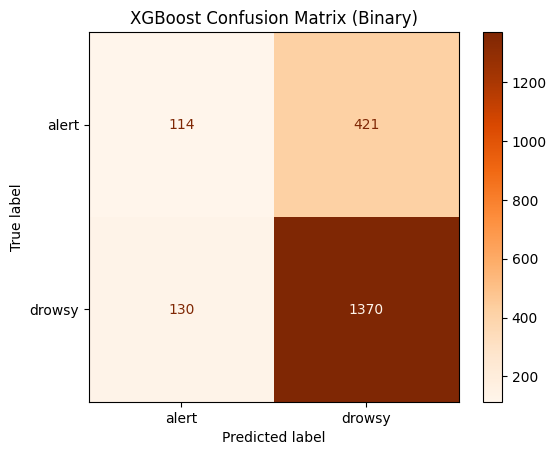

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Label mapping ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Feature selection ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode multiclass labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Balance with SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train multiclass XGBoost ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_sm, y_train_sm)

# --- Predict multiclass ---
y_pred_mc = xgb_model.predict(X_test)
y_proba_mc = xgb_model.predict_proba(X_test)  # shape: (n_samples, 3)

# ===========================================
# Convert multiclass → binary (alert vs drowsy)
# ===========================================

# Define mapping function
def multiclass_to_binary(y):
    return np.where(np.isin(y, [le.transform(['slightly'])[0], le.transform(['moderate_very'])[0]]), 1, 0)

# Apply mapping to true and predicted labels
y_test_bin = multiclass_to_binary(y_test_enc)
y_pred_bin = multiclass_to_binary(y_pred_mc)

# Compute P(drowsy) = P(slightly) + P(moderate_very)
drowsy_indices = [le.transform(['slightly'])[0], le.transform(['moderate_very'])[0]]
y_proba_bin = y_proba_mc[:, drowsy_indices].sum(axis=1)

# --- Binary Evaluation ---
print("XGBoost (Binary Evaluation):\n")
print(classification_report(
    y_test_bin,
    y_pred_bin,
    target_names=['alert', 'drowsy']
))

# --- F1 Scores ---
f1_bin_macro = f1_score(y_test_bin, y_pred_bin, average='macro')
f1_bin_weighted = f1_score(y_test_bin, y_pred_bin, average='weighted')
print(f"Binary F1 Score (macro): {f1_bin_macro:.4f}")
print(f"Binary F1 Score (weighted): {f1_bin_weighted:.4f}")

# --- ROC AUC ---
auc_bin = roc_auc_score(y_test_bin, y_proba_bin)
print(f"Binary ROC AUC: {auc_bin:.4f}")

# --- Confusion Matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_bin,
    y_pred_bin,
    display_labels=['alert', 'drowsy'],
    cmap='Oranges'
)
plt.title("XGBoost Confusion Matrix (Binary)")
plt.show()

Iteration 1, loss = 2.65737455
Validation score: 0.578992
Iteration 2, loss = 0.71156325
Validation score: 0.618275
Iteration 3, loss = 0.65947152
Validation score: 0.648164
Iteration 4, loss = 0.63080969
Validation score: 0.664389
Iteration 5, loss = 0.62619437
Validation score: 0.691716
Iteration 6, loss = 0.62286425
Validation score: 0.591802
Iteration 7, loss = 0.61277917
Validation score: 0.705380
Iteration 8, loss = 0.62112462
Validation score: 0.713920
Iteration 9, loss = 0.60708112
Validation score: 0.637916
Iteration 10, loss = 0.60732441
Validation score: 0.712212
Iteration 11, loss = 0.60712403
Validation score: 0.698548
Iteration 12, loss = 0.57277414
Validation score: 0.722459
Iteration 13, loss = 0.55702538
Validation score: 0.658412
Iteration 14, loss = 0.61512544
Validation score: 0.664389
Iteration 15, loss = 0.61770183
Validation score: 0.713920
Iteration 16, loss = 0.57417421
Validation score: 0.733561
Iteration 17, loss = 0.57052897
Validation score: 0.726729
Iterat

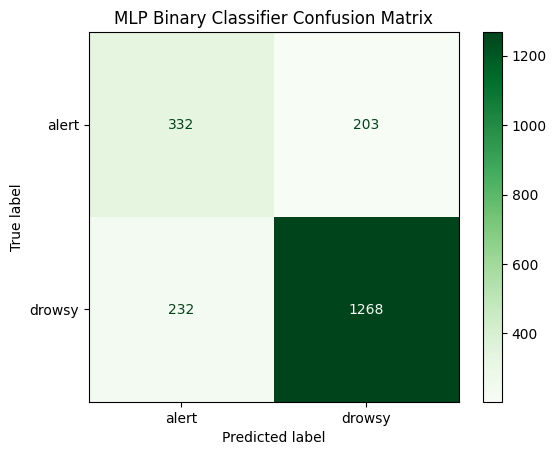

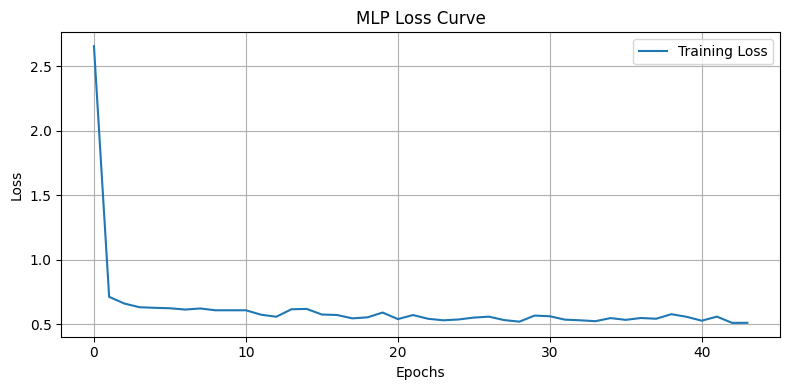

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Apply label mapping ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Convert to binary labels ---
train_df['BinaryLabel'] = np.where(train_df['Label'] == 'alert', 'alert', 'drowsy')
test_df['BinaryLabel'] = np.where(test_df['Label'] == 'alert', 'alert', 'drowsy')

# --- Feature selection ---
non_features = ['ID', 'Study', 'window_start', 'Label', 'BinaryLabel']
features = [col for col in train_df.columns if col not in non_features]

# --- Extract features and labels ---
X_train = train_df[features]
y_train = train_df['BinaryLabel']
X_test = test_df[features]
y_test = test_df['BinaryLabel']

# --- Encode binary labels ---
le_bin = LabelEncoder()
y_train_enc = le_bin.fit_transform(y_train)
y_test_enc = le_bin.transform(y_test)

# --- Balance training data ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train-validation split ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_sm, y_train_sm, test_size=0.2, random_state=42, stratify=y_train_sm
)

# --- Define MLP model ---
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

# --- Fit model ---
mlp.fit(X_tr, y_tr)

# --- Predict ---
y_pred = mlp.predict(X_test)
y_proba = mlp.predict_proba(X_test)[:, 1]  # prob of drowsy

# --- Evaluation ---
print("MLP Binary Classifier:\n")
print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le_bin.classes_
))

# --- Balanced F1 Scores ---
f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# --- ROC AUC ---
auc_score = roc_auc_score(y_test_enc, y_proba)
print(f"ROC AUC: {auc_score:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred,
    display_labels=le_bin.classes_,
    cmap='Greens'
)
plt.title("MLP Binary Classifier Confusion Matrix")
plt.show()

# --- Loss curve ---
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Random Forest (Binary Evaluation: alert/slightly vs moderate_very):

                precision    recall  f1-score   support

alert/slightly       0.86      0.73      0.79      1357
 moderate_very       0.58      0.77      0.67       678

      accuracy                           0.74      2035
     macro avg       0.72      0.75      0.73      2035
  weighted avg       0.77      0.74      0.75      2035

Binary F1 Score (macro): 0.7271
Binary F1 Score (weighted): 0.7477
Binary ROC AUC: 0.8211


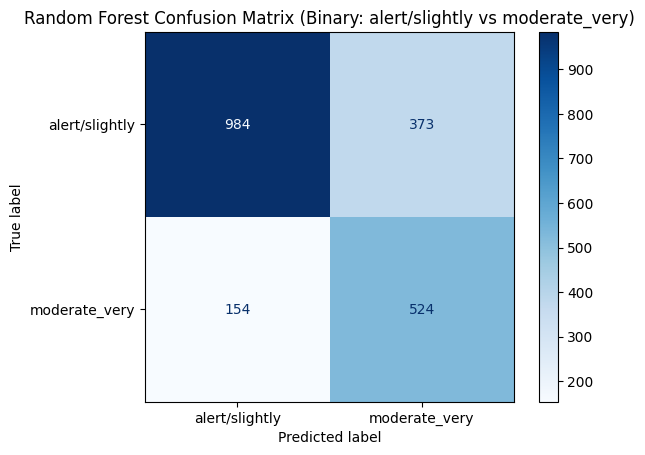

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# --- Load data ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Apply label map ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Features ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels (multiclass) ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- SMOTE on multiclass labels ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train multiclass Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

# --- Predict multiclass ---
y_pred_mc = rf_model.predict(X_test)
y_proba_mc = rf_model.predict_proba(X_test)  # Shape: (n_samples, 3)

# ===============================
# Recast multiclass → binary
# ===============================

# Get class name mapping
class_names = le.classes_

# Define binary mapping: 1 = moderate_very, 0 = alert/slightly
def multiclass_to_binary(y):
    return np.where(np.isin(y, [le.transform(['moderate_very'])[0]]), 1, 0)

# --- Convert predictions and true labels to binary ---
y_test_bin = multiclass_to_binary(y_test_enc)
y_pred_bin = multiclass_to_binary(y_pred_mc)

# --- Compute probability of "moderate_very" ---
mod_very_index = [le.transform(['moderate_very'])[0]]
y_proba_bin = y_proba_mc[:, mod_very_index].sum(axis=1)  # P(moderate_very)

# --- Evaluate Binary Classification ---
print("Random Forest (Binary Evaluation: alert/slightly vs moderate_very):\n")
print(classification_report(
    y_test_bin,
    y_pred_bin,
    target_names=['alert/slightly', 'moderate_very']
))

# --- Binary F1 Score ---
f1_bin_macro = f1_score(y_test_bin, y_pred_bin, average='macro')
f1_bin_weighted = f1_score(y_test_bin, y_pred_bin, average='weighted')
print(f"Binary F1 Score (macro): {f1_bin_macro:.4f}")
print(f"Binary F1 Score (weighted): {f1_bin_weighted:.4f}")

# --- ROC AUC for binary ---
auc_bin = roc_auc_score(y_test_bin, y_proba_bin)
print(f"Binary ROC AUC: {auc_bin:.4f}")

# --- Binary confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_bin,
    y_pred_bin,
    display_labels=['alert/slightly', 'moderate_very'],
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Binary: alert/slightly vs moderate_very)")
plt.show()


Alert/Moderate_Very misclassified as Slightly: 476 samples
Random Forest (Alert vs Moderate_Very Evaluation):

               precision    recall  f1-score   support

        alert       0.73      0.77      0.75       535
moderate_very       0.81      0.77      0.79       678

     accuracy                           0.77      1213
    macro avg       0.77      0.77      0.77      1213
 weighted avg       0.77      0.77      0.77      1213

Binary F1 Score (macro): 0.7688
Binary F1 Score (weighted): 0.7713
Binary ROC AUC: 0.8520


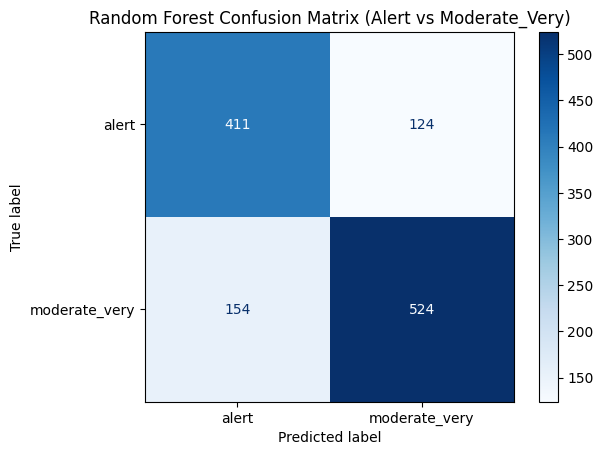

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# --- Load data ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Apply label map ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Features ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels (multiclass) ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- SMOTE on multiclass labels ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train multiclass Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

# --- Predict multiclass ---
y_pred_mc = rf_model.predict(X_test)
y_proba_mc = rf_model.predict_proba(X_test)  # Shape: (n_samples, 3)

# --- Count how many A/MV samples were misclassified as S ---
# Get the class index for 'slightly'
slightly_idx = le.transform(['slightly'])[0]

# Mask for test samples that are A or MV
am_mask = test_df['Label'].isin(['alert', 'moderate_very'])

# Ground truth and predictions for those
y_true_am = y_test_enc[am_mask]
y_pred_am = y_pred_mc[am_mask]

# Count how many were predicted as 'slightly'
misclassified_as_slightly = np.sum(y_pred_am == slightly_idx)

print(f"\nAlert/Moderate_Very misclassified as Slightly: {misclassified_as_slightly} samples")

# ===============================
# Recast multiclass → binary (alert vs moderate_very)
# ===============================

# Filter test set to only include alert and moderate_very
valid_classes = ['alert', 'moderate_very']
valid_indices = test_df['Label'].isin(valid_classes)

# Subset features and labels
X_test_bin = X_test[valid_indices]
y_test_bin = y_test[valid_indices]

# Encode using same LabelEncoder
y_test_enc_bin = le.transform(y_test_bin)

# Predict using RF
y_pred_mc_bin = rf_model.predict(X_test_bin)
y_proba_mc_bin = rf_model.predict_proba(X_test_bin)

# Class indices
alert_idx = le.transform(['alert'])[0]
modvery_idx = le.transform(['moderate_very'])[0]

# Binary mapping: 0 = alert, 1 = moderate_very
def map_alert_vs_modvery(y):
    return np.where(y == modvery_idx, 1, 0)

# Apply to test labels and predictions
y_test_alert_mod = map_alert_vs_modvery(y_test_enc_bin)
y_pred_alert_mod = map_alert_vs_modvery(y_pred_mc_bin)

# Probabilities for moderate_very class
y_proba_alert_mod = y_proba_mc_bin[:, modvery_idx]

# --- Evaluation ---
print("Random Forest (Alert vs Moderate_Very Evaluation):\n")
print(classification_report(
    y_test_alert_mod,
    y_pred_alert_mod,
    target_names=['alert', 'moderate_very']
))

# F1 Scores
f1_bin_macro = f1_score(y_test_alert_mod, y_pred_alert_mod, average='macro')
f1_bin_weighted = f1_score(y_test_alert_mod, y_pred_alert_mod, average='weighted')
print(f"Binary F1 Score (macro): {f1_bin_macro:.4f}")
print(f"Binary F1 Score (weighted): {f1_bin_weighted:.4f}")

# ROC AUC
auc_bin = roc_auc_score(y_test_alert_mod, y_proba_alert_mod)
print(f"Binary ROC AUC: {auc_bin:.4f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_alert_mod,
    y_pred_alert_mod,
    display_labels=['alert', 'moderate_very'],
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Alert vs Moderate_Very)")
plt.show()

In [ ]:
# Try finding out how many alert and moderate_very samples are misclassified as slightly


Alert/Moderate_Very misclassified as Slightly: 476 samples
Random Forest Binary Evaluation (Alert vs Moderate_Very) — with Slightly in Predictions:

               precision    recall  f1-score   support

        alert       0.73      0.77      0.75       535
moderate_very       0.81      0.77      0.79       678

     accuracy                           0.77      1213
    macro avg       0.77      0.77      0.77      1213
 weighted avg       0.77      0.77      0.77      1213

Binary F1 Score (macro): 0.7688
Binary F1 Score (weighted): 0.7713
Binary ROC AUC (Alert vs Moderate_Very): 0.8520


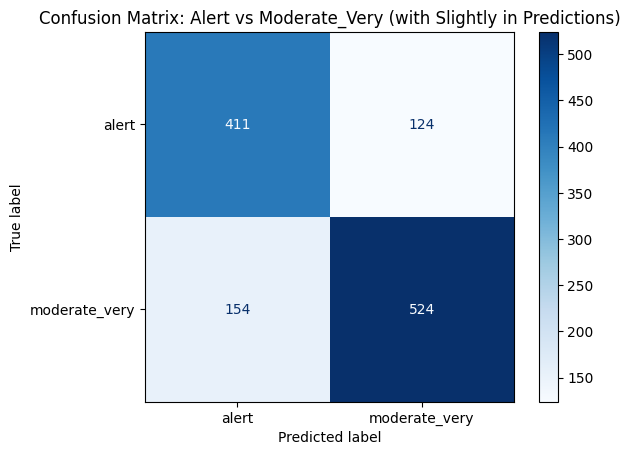

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# --- Load data ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Apply label map ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Features ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels (multiclass) ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- SMOTE on multiclass labels ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train multiclass Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

# --- Predict multiclass ---
y_pred_mc = rf_model.predict(X_test)
y_proba_mc = rf_model.predict_proba(X_test)  # Shape: (n_samples, 3)

# --- Count how many A/MV samples were misclassified as S ---
# Get the class index for 'slightly'
slightly_idx = le.transform(['slightly'])[0]

# Mask for test samples that are A or MV
am_mask = test_df['Label'].isin(['alert', 'moderate_very'])

# Ground truth and predictions for those
y_true_am = y_test_enc[am_mask]
y_pred_am = y_pred_mc[am_mask]

# Count how many were predicted as 'slightly'
misclassified_as_slightly = np.sum(y_pred_am == slightly_idx)

print(f"\nAlert/Moderate_Very misclassified as Slightly: {misclassified_as_slightly} samples")

# ===============================
# Recast multiclass → binary (alert vs moderate_very)
# ===============================

# # Filter test set to only include alert and moderate_very
# valid_classes = ['alert', 'moderate_very']
# valid_indices = test_df['Label'].isin(valid_classes)

# # Subset features and labels
# X_test_bin = X_test[valid_indices]
# y_test_bin = y_test[valid_indices]

# Encode using same LabelEncoder
y_test_enc_bin = le.transform(y_test_bin)

# Predict using RF
y_pred_mc_bin = rf_model.predict(X_test_bin)
y_proba_mc_bin = rf_model.predict_proba(X_test_bin)

# Class indices
alert_idx = le.transform(['alert'])[0]
modvery_idx = le.transform(['moderate_very'])[0]

# Binary mapping: 0 = alert, 1 = moderate_very
def map_alert_vs_modvery(y):
    return np.where(y == modvery_idx, 1, 0)

# Apply to test labels and predictions
y_test_alert_mod = map_alert_vs_modvery(y_test_enc_bin)
y_pred_alert_mod = map_alert_vs_modvery(y_pred_mc_bin)

# Probabilities for moderate_very class
y_proba_alert_mod = y_proba_mc_bin[:, modvery_idx]

# --- Evaluation ---
print("Random Forest (Alert vs Moderate_Very Evaluation):\n")
print(classification_report(
    y_test_alert_mod,
    y_pred_alert_mod,
    target_names=['alert', 'moderate_very']
))

# F1 Scores
f1_bin_macro = f1_score(y_test_alert_mod, y_pred_alert_mod, average='macro')
f1_bin_weighted = f1_score(y_test_alert_mod, y_pred_alert_mod, average='weighted')
print(f"Binary F1 Score (macro): {f1_bin_macro:.4f}")
print(f"Binary F1 Score (weighted): {f1_bin_weighted:.4f}")

# ROC AUC
auc_bin = roc_auc_score(y_test_alert_mod, y_proba_alert_mod)
print(f"Binary ROC AUC: {auc_bin:.4f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_alert_mod,
    y_pred_alert_mod,
    display_labels=['alert', 'moderate_very'],
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Alert vs Moderate_Very)")
plt.show()

Iteration 1, loss = 3.73031044
Validation score: 0.656522
Iteration 2, loss = 0.71542798
Validation score: 0.652174
Iteration 3, loss = 0.61921939
Validation score: 0.662319
Iteration 4, loss = 0.73137034
Validation score: 0.678261
Iteration 5, loss = 0.57079826
Validation score: 0.672464
Iteration 6, loss = 0.56439981
Validation score: 0.685507
Iteration 7, loss = 0.56807735
Validation score: 0.666667
Iteration 8, loss = 0.58083701
Validation score: 0.686957
Iteration 9, loss = 0.55533174
Validation score: 0.707246
Iteration 10, loss = 0.52916216
Validation score: 0.702899
Iteration 11, loss = 0.51598190
Validation score: 0.704348
Iteration 12, loss = 0.52157202
Validation score: 0.692754
Iteration 13, loss = 0.54115429
Validation score: 0.702899
Iteration 14, loss = 0.53107225
Validation score: 0.697101
Iteration 15, loss = 0.52543929
Validation score: 0.608696
Iteration 16, loss = 0.53981532
Validation score: 0.634783
Iteration 17, loss = 0.61955946
Validation score: 0.730435
Iterat

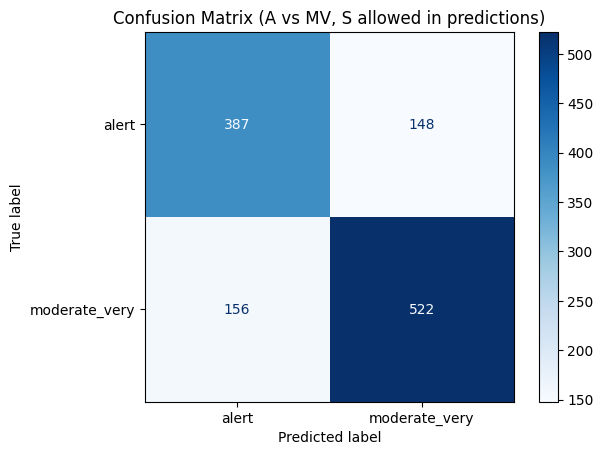

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Apply label mapping ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# Step 1: Keep only 'alert' and 'moderate_very' in training
train_df = train_df[train_df['Label'].isin(['alert', 'moderate_very'])]

# Step 2: Define BinaryLabel column
train_df['BinaryLabel'] = train_df['Label']
test_df['BinaryLabel'] = test_df['Label'].where(test_df['Label'].isin(['alert', 'moderate_very']), np.nan)

# Step 3: Feature columns
non_features = ['ID', 'Study', 'window_start', 'Label', 'BinaryLabel']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['BinaryLabel']
X_test = test_df[features]
y_test_full = test_df['BinaryLabel']  # contains NaNs for 'slightly'

# Step 4: Encode binary labels
le_bin = LabelEncoder()
y_train_enc = le_bin.fit_transform(y_train)

# Step 5: SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train_enc)

# Step 6: Train model
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)
mlp.fit(X_train_sm, y_train_sm)

# Step 7: Predict on full test set
y_pred_full = mlp.predict(X_test)
y_proba_full = mlp.predict_proba(X_test)

# Step 8: Evaluate only where ground truth is alert or moderate_very
valid_mask = y_test_full.notna()
y_test_eval = le_bin.transform(y_test_full[valid_mask])
y_pred_eval = y_pred_full[valid_mask]
y_proba_eval = y_proba_full[valid_mask][:, le_bin.transform(['moderate_very'])[0]]

from sklearn.metrics import classification_report, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Binary Evaluation (Alert vs Moderate_Very) — Slightly Allowed in Predictions\n")

print(classification_report(
    y_test_eval,
    y_pred_eval,
    labels=[0, 1],
    target_names=le_bin.classes_
))

print(f"F1 Score (macro): {f1_score(y_test_eval, y_pred_eval, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test_eval, y_pred_eval, average='weighted'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_eval, y_proba_eval):.4f}")

ConfusionMatrixDisplay.from_predictions(
    y_test_eval,
    y_pred_eval,
    display_labels=le_bin.classes_,
    cmap='Blues'
)
plt.title("Confusion Matrix (A vs MV, S allowed in predictions)")
plt.show()